In [ ]:
import numpy as np  # for array stuff and random
import random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib import style  # to make pretty charts because it matters.
import os

import torch
import gym
from gym import spaces
from gym import envs
from gym.utils import seeding, EzPickle

In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.set_deterministic(True)
    #torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.deterministic = True

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C

In [ ]:
model = A2C.load("PPO_test_modflow_multiInflow_coast_1")
env = gym.make('pumpingAllocation-v4')

#Pick scenerio
scenerio = 8

p = [0]*10
p[scenerio-1] = 1
#p = [0,0,0,0,0,0,0,0.5, 0.5, 0]

env.river_p = p
env.demands_p = [1,0]

SW, GW, Sup, D = [], [], [], []
deficit=[]
S, h, inflow = [], [], []
Z_mean = []
rewards = []
env.ifRandtt = False

for i in range(1):
    print('----------test',i+1,'start-------------')
    state = env.reset()
    total_step=0
    while True:
        action, _states = model.predict(state,deterministic=True )
        #print(action, _states)
        next_state, reward, done, info = env.step(action)
        #print(next_state,reward,done)
        
        #還原標準化
        month = (total_step//3)%12+1
        #month = (state[3]+1)/2*11+1
        storage = (state[0]+1)/2*23500
        Zmin_before = (state[1]+1)/2*100-100
        Zmin_after = (next_state[1]+1)/2*100-100
        #demand = (state[2]+1)/2*(3006.85-1201.95+400)+1300-200
        demand = env.demand
        inf = (state[4]+1)/2*(30721.8-336.2+200)+336.2-200
        
        sw = env.sw
        gw = action[1]*216*240*20/10000
        
        print(f'{month:2.0f}月, 第{total_step+1:2.0f}旬, 水庫水量:{storage:5.0f}, 水位(前、後):{Zmin_before:5.1f}→{Zmin_after:4.1f}, Action:{action}, SW、GW:[{sw:3.0f}, {gw:3.0f}], 需水量:{demand:4.0f}, Reward: {reward:.1f}')
        
        SW.append(sw)
        GW.append(gw)
        Sup.append(sw+gw)
        D.append(demand)
        deficit.append(demand-sw-gw)
        S.append(storage)
        h.append(Zmin_before)
        Z_mean.append(env.Zmean)
        inflow.append(inf)
        rewards.append(reward)
        
        
        state = next_state
        total_step+=1

        if done:
            break


In [5]:
scenerio+=2011

c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


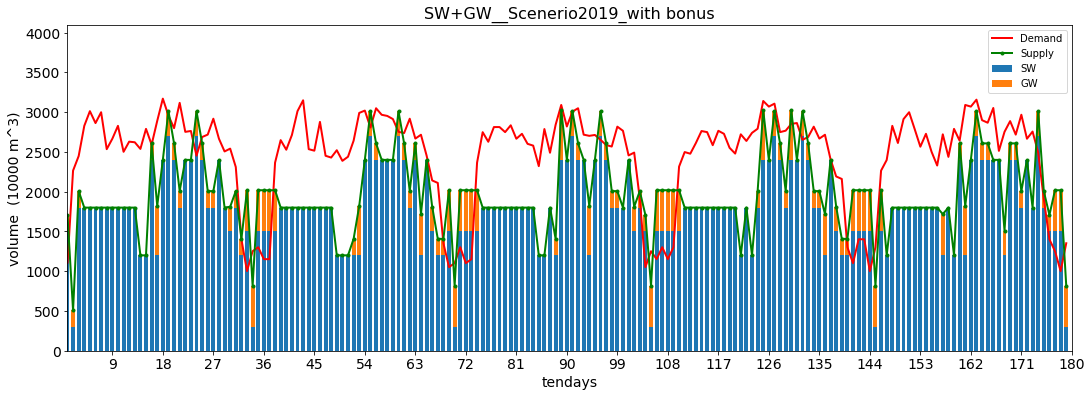

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
end=180
policy_type='_with bonus'

df = pd.DataFrame({'SW':SW[:end],
                   'GW':GW[:end],
                   'Supply':Sup[:end],
                   'Demand':D[:end],
                   'ith period of tendays':[i for i in range(1,end+1)],
                   'deficit':deficit[:end],
                   'Storage':S[:end],
                   'h_min':h[:end],
                   'Inflow':inflow[:end],
                   'deficit_rate':[(b-a)/b*100 for a,b in zip(Sup[:end],D[:end])],
                   'reward':rewards[:end],
                   'h_avg':Z_mean[:end]
                  }) 


ax = df[['SW','GW']].plot(kind='bar', stacked=True, figsize=(18,6), width=0.7,
                          xlim=[1,180], ylim=[0,4100], xticks=[9*i for i in range(1,21)], fontsize=14)
df['Demand'].plot(kind='line', color='#FF0000', lw=2, xlim=[1,180],legend=True)
df['Supply'].plot(kind='line', style='g.-', lw=2, xlim=[1,180],legend=True)
ax.set_title('SW+GW__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("volume  (10000 m^3)", fontsize=14)
ax.legend()

c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


63.72729865741483
0.35404054809674906


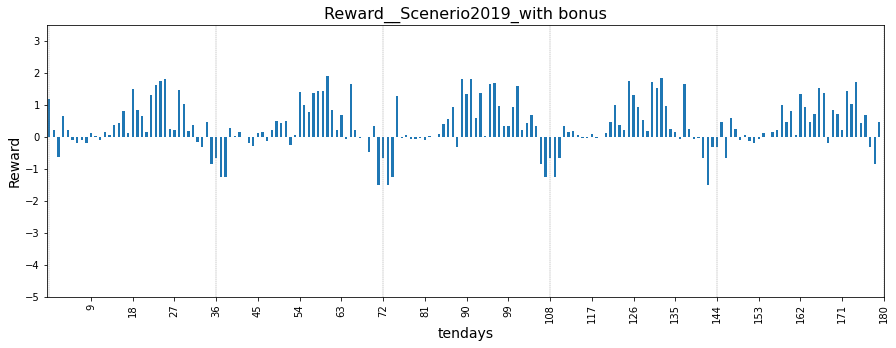

In [12]:
#reward
ax = df['reward'].plot(kind='bar', figsize=(15,5), lw=1.5, xlim=[1,180], ylim=[-5,3.5], 
                        style='r.-', xticks=[9*i for i in range(1,21)], fontsize=10)
#ax.set_title('deficit_rate', fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("Reward", fontsize=14)
ax.set_title('Reward__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")


print(df['reward'].sum())
print(df['reward'].mean())

c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


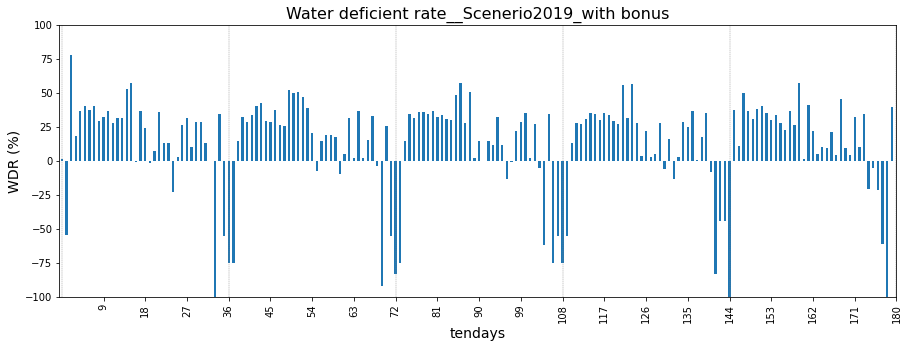

In [8]:
ax = df['deficit_rate'].plot(kind='bar', figsize=(15,5), lw=1.5, xlim=[1,180], ylim=[-100,100], 
                        style='r.-', xticks=[9*i for i in range(1,21)], fontsize=10)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("WDR (%)", fontsize=14)
ax.set_title('Water deficient rate__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")

c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


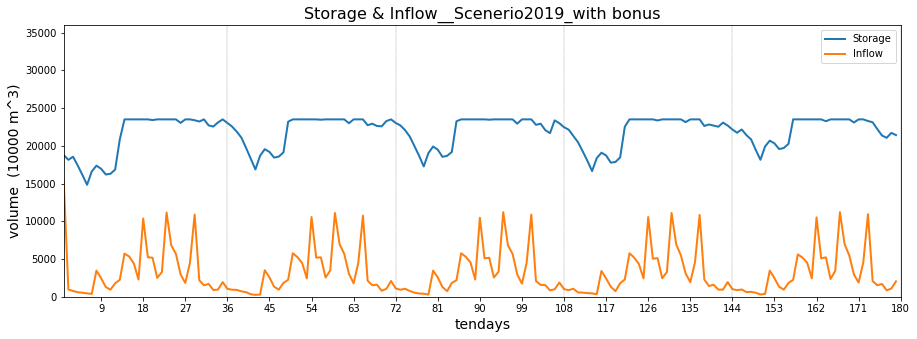

In [9]:
ax = df[['Storage','Inflow']].plot(kind='line', lw='2', figsize=(15,5),xlim=[1,180], ylim=[0,36000], xticks=[9*i for i in range(1,21)])
ax.set_title('Storage & Inflow__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("volume  (10000 m^3)", fontsize=14)
ax.legend()

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")

c:\users\johnny\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


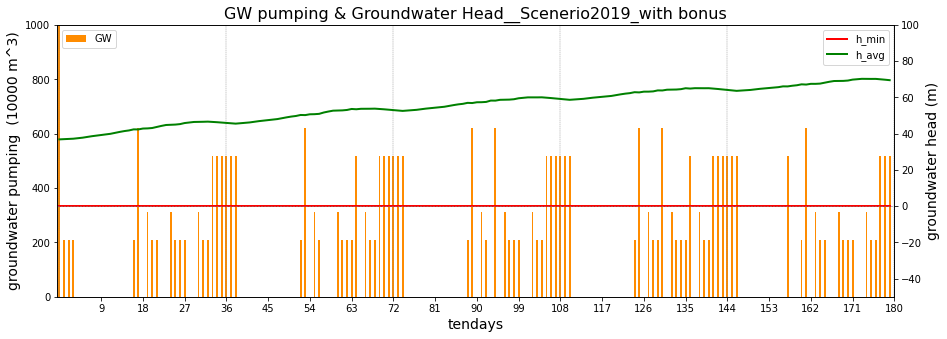

In [10]:
ax = df['GW'].plot(kind='bar', color='darkorange', figsize=(15,5), xlim=[1,180],ylim=[0,1000],width=0.4, xticks=[9*i for i in range(1,21)], legend=True)
ax2 = df['h_min'].plot(kind='line', secondary_y = True,  lw=2, color='#FF0000', legend=True)
ax3 = df['h_avg'].plot(kind='line', secondary_y = True,  lw=2, color='green', legend=True)
ax.set_title('GW pumping & Groundwater Head__Scenerio{}{}'.format(scenerio,policy_type), fontsize=16)
ax.set_xlabel("tendays", fontsize=14)
ax.set_ylabel("groundwater pumping  (10000 m^3)", fontsize=14)

for i in range(6):
    ax.axvline(36*i, color="grey",lw=0.4, linestyle="dashed")
ax2.axhline(0, color="grey",lw=0.6, linestyle="dashed")
    
ax2.set_ylabel("groundwater head (m)", fontsize=14)
ax2.set_ylim(-50, 100)
ax.legend(loc=2)
ax2.legend(loc=1)

